# MOVIES RECOMMENDATION

# Table of Contents
   * [Introduction](#Introduction)
   * [Problem definition, exploratory data analysis and pre-processing steps](#Problem-definition,-exploratory-data-analysis-and-pre-processing-steps)
      - [Problem definition](#Problem-definition)
      - [Pre-Processing](#Pre-Processing)
      - [Exploratory Data Analysis](#Exploratory-Data-Analysis)
   * [Experimental Setup and Obtained Results](#Experimental-Setup-and-Obtained-Resultss)
      - [1. BINARY](#1.-BINARY)
          - [a) Popularity](#(a)--Popularity:)
          - [b) Association Rules](#(b)--Association-Rules:)
          - [c) Collaborative Filtering](#(c)--Collaborative-Filtering:)
      - [2. BINARY](#1.-BINARY)
          - [a) Popularity](#(a)-Popularity:)
          - [b) Association Rules](#(b)-Association-Rules:)
          - [c) Collaborative Filtering](#(c)-Collaborative-Filtering:)
      - [3. Context-Aware Recommendation](#3.-Context-Aware-Recommendation)
   * [Conclusions, shortcomings and future work](#Conclusions,-shortcomings-and-future-work)
   * [References](#References)
          

# Introduction
In this practical assignment, our objective is to obtain recommendations of movies as well as to compare the performance of different recommendation strategies on a data set obtained from RottenTomatoes.
This data set is splited in two files:
* movies.tsv: which contains basic movie information
* reviews.tsv: which contains reviews that critics have given to a movie

This assignment consists of three main tasks:
1. Preliminary exploratory data analysis
2. From binary and non-binary data, learn recommender systems based on:
  * Popularity
  * Association Rules
  * Collaborative Filtering
3. Context-aware recommendation

First of all, we started by loading the data sets into variables

In [1]:
import pandas as pd

reviews = pd.read_csv("reviews.tsv", sep="\t")
movie_info = pd.read_csv("movie_info.tsv", sep="\t")

In [2]:
reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [3]:
movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


# Problem definition, exploratory data analysis and pre-processing steps
In this step, our first objective was to analyze the data, in order to know what was or was not necessary to us. For this we start by printing some information such as can be seen below:


What was done:
* Removed reviews with no rating or review;
* Converted all ratings to one single scale /10;
* TODO

In [4]:
print("Number of reviews: ", len(reviews))
print("Number of movies: ", len(movie_info))

Number of reviews:  54432
Number of movies:  1560


Find movies that have been reviewed

In [5]:
print("Number of movies that have been reviewed: ", len(reviews['id'].unique()))

Number of movies that have been reviewed:  1135


Find movies that haven't been reviewed

In [6]:
print("Number of movies that haven't been reviewed: ", len(movie_info)- len(reviews['id'].unique()))

Number of movies that haven't been reviewed:  425


Find reviews with no rating

In [7]:
print("Number of reviews with no rating: ", len(reviews.loc[reviews['rating'].isnull()]))

Number of reviews with no rating:  13517


Find reviews with no rating and no review

In [8]:
print("Number of reviews with no rating and review:", len(reviews.loc[reviews['rating'].isnull() & reviews['review'].isnull()]))

Number of reviews with no rating and review: 27


The first thing we've noticed was that there are 13517 reviews with no rating (24.83% of reviews). And there are 27 reviews with no rating and a review (0.05% of reviews), that is, those reviews only have the fresh parameter. 
That said, we decided to discard reviews that have no rating, and reviews that only have information about the fresh parameter, so that the number of reviews analyzed for recommendations based on binary and non-binary data are the same.

Regarding the movie data, of the 1560 movies that exist in the dataset, 425 did not have any reviews made (27% of the movies), that said, we've decided to only take into account movies that were reviewed.

## Pre-Processing 

In [9]:
from pre_processing import *

Remove reviews with no rating

In [10]:
reviews_bf = reviews.copy()
reviews = reviews.loc[~reviews['rating'].isnull()]

Remove movies that dont have reviews

In [11]:
# Get all unique ids from reviews
reviews_ids = list(set(reviews['id'].tolist()))

movie_info = movie_info[movie_info['id'].isin(reviews_ids)]

### Ratings
Regarding the ratings given in reviews, due to the fact that there are several scales (star scale (1-5), 1-10 continuous scale, letter grades, etc.), we have chosen to convert all the ratings to a single scale, that scale beeing from 0 to 10.
```
Converting all ratings to one single scale /10
For any v/m , being v the value and m the max value in the scale, the new rating will be (v * 10)/m
Note: We haven't been able to convert: 
        Single numbers like ['1', '6', ...] since we don't know the corresponding scale.
        Also cases where the rating given is bigger than the scale e.g.(3/2)
Scales that we cannot convert we've decided to discarded
```

In [12]:
convert_ratings(reviews)

# Remove reviews with no scale
reviews = reviews.loc[~reviews['rating'].isnull()]
reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,6.000000,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
6,3,"Quickly grows repetitive and tiresome, meander...",4.166667,rotten,Eric D. Snider,0,EricDSnider.com,"July 17, 2013"
7,3,Cronenberg is not a director to be daunted by ...,4.000000,rotten,Matt Kelemen,0,Las Vegas CityLife,"April 21, 2013"
11,3,"While not one of Cronenberg's stronger films, ...",5.833333,fresh,Emanuel Levy,0,EmanuelLevy.Com,"February 3, 2013"
12,3,Robert Pattinson works mighty hard to make Cos...,5.000000,rotten,Christian Toto,0,Big Hollywood,"January 15, 2013"


### Creating necessary variables and DataFrames

In [13]:
reviews_rs, critics, critic_uid = create_rs_df(reviews)
reviews_rs.head()

,critic_uid,id,rating
0,0,3,6.000000
6,1,3,4.166667
7,2,3,4.000000
11,3,3,5.833333
12,4,3,5.000000


In [14]:
ratings_mean_count = creat_ratings_mean_count(reviews)
ratings_mean_count.head()

,rating,rating_counts
id,,
3,5.742925,106
5,6.444444,18
6,5.890244,41
8,6.899123,38
10,5.605932,59


### Exploratory Data Analysis

In [15]:
from exploratory_data_analysis import *
%matplotlib inline

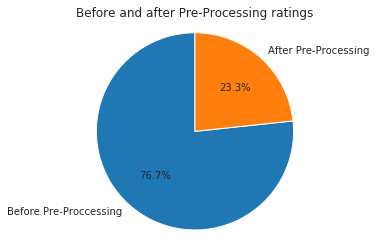

In [16]:
plot_pre_processing(reviews_bf, reviews)

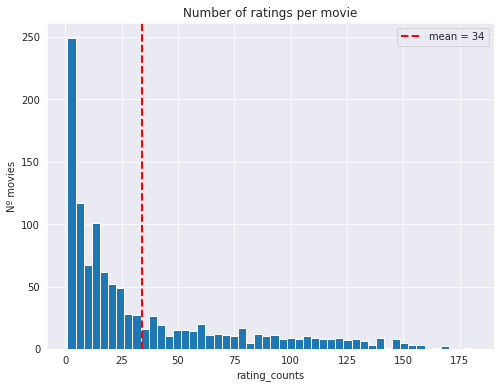

In [17]:
plot_nratings_per_movie(ratings_mean_count)

In this graph we can see that most of the films have less than 25 ratings, and that few films have more than 50 ratings. With each movie averaging 34 ratings.

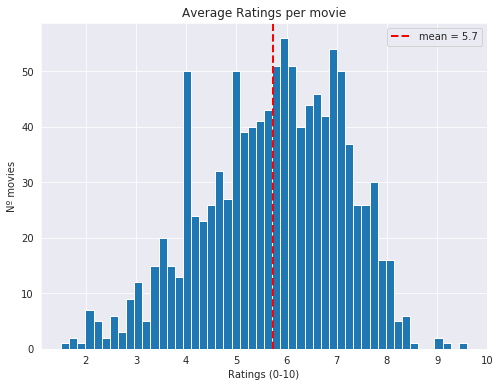

In [18]:
plot_average_ratings_per_movie(ratings_mean_count)

Here we can see the normal distribution of the ratings, with a mean of around 5.7.

<Figure size 576x432 with 0 Axes>

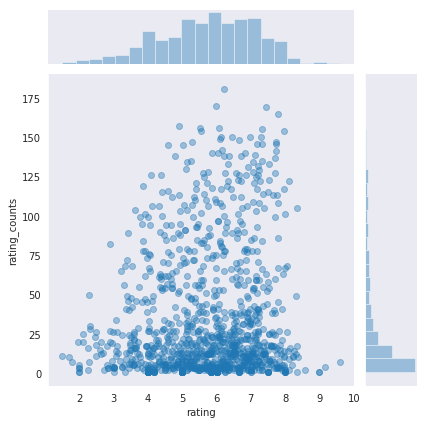

In [19]:
plot_average_against_nratings_per_movie(ratings_mean_count)

Here we can see the last two charts in one, where we conclude that movies with a rating lower or near the average of ratings, have a lower number of ratings given, and movies with higher ratings, have a higher number of ratings.

# Experimental Setup and Obtained Results
## Recommender Systems

###  1. BINARY

In [20]:
from recommender_systems import Binary
binary = Binary(reviews, reviews_rs, critic_uid)

### a) Popularity:
Returns the movie with the most reviews.

Top 1 Movies Recommendation

In [21]:
binary.binary_popularity_based(1)

movie_id: 1136 with number of rating: 181


Top 2 Movies Recommendation

In [22]:
binary.binary_popularity_based(2)

movie_id: 1136 with number of rating: 181
movie_id: 1071 with number of rating: 170


Top 5 Movies Recommendation

In [23]:
binary.binary_popularity_based(5)

movie_id: 1136 with number of rating: 181
movie_id: 1071 with number of rating: 170
movie_id: 1704 with number of rating: 169
movie_id: 1525 with number of rating: 165
movie_id: 1325 with number of rating: 157


### b) Association Rules:


In [24]:
df = binary.ar_create_df()
df.head()

,3,5,6,8,10,13,14,15,17,19,...,1987,1991,1992,1993,1995,1996,1997,1998,1999,2000
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,True,True,False,False,False,False,True,False,False,...,True,True,True,True,False,False,True,False,True,True
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [25]:
frequent_itemsets = binary.frequent_itemsets(df, min_support=0.03, verbose=0)
frequent_itemsets

,support,itemsets
0,0.043659,(3)
1,0.060291,(23)
2,0.034511,(26)
3,0.031185,(40)
4,0.052391,(57)
5,0.054886,(65)
6,0.057796,(77)
7,0.040748,(95)
8,0.033680,(99)
9,0.039085,(108)


In [26]:
rules = binary.association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1017),(338),0.056965,0.063617,0.030353,0.532847,8.375793,0.026729,2.004444
1,(1695),(1935),0.051975,0.059044,0.036590,0.704000,11.923380,0.033522,3.178907
2,(1935),(1695),0.059044,0.051975,0.036590,0.619718,11.923380,0.033522,2.492954
3,(841),(443),0.059459,0.057380,0.034096,0.573427,9.993412,0.030684,2.209747
4,(443),(841),0.057380,0.059459,0.034096,0.594203,9.993412,0.030684,2.317761
5,(841),(1071),0.059459,0.068607,0.032432,0.545455,7.950413,0.028353,2.049064
6,(1585),(1935),0.051143,0.059044,0.032017,0.626016,10.602599,0.028997,2.516035
7,(1935),(1585),0.059044,0.051143,0.032017,0.542254,10.602599,0.028997,2.072887
8,(976),(1071),0.050312,0.068607,0.032848,0.652893,9.516404,0.029396,2.683299
9,(1525),(1136),0.067360,0.073181,0.034096,0.506173,6.916737,0.029166,1.876809


In [27]:
binary.get_ar_recommendation(df, rules, 100, critics, top_n=2)

Top movies for reviewer 100: Kimberly Gadette
movie_id: 338
movie_id: 1136


### c) Collaborative Filtering:
Based on: 
* https://medium.com/radon-dev/item-item-collaborative-filtering-with-binary-or-unary-data-e8f0b465b2c3

Top 5 Movies Recommendation for movie_id = 3

In [28]:
binary.binary_collab_item_based(3, 5)

Top 5 movie recommendation based on movie_id = 3:
movie_id: 3 with similarity: 1.0
movie_id: 1646 with similarity: 0.132
movie_id: 188 with similarity: 0.13
movie_id: 1136 with similarity: 0.124
movie_id: 23 with similarity: 0.122
movie_id: 1083 with similarity: 0.119


Top 5 Movies Recommendation for user 'Kimberly Gadette'

In [29]:
binary.binary_collab_user_based('Kimberly Gadette', 5)

Top 5 movie recommendation based on critic_id = Kimberly Gadette:
movie_id: 258 with similarity: 0.029
movie_id: 988 with similarity: 0.021
movie_id: 357 with similarity: 0.021
movie_id: 1944 with similarity: 0.02
movie_id: 791 with similarity: 0.02


###  2. NON-BINARY

In [30]:
from recommender_systems import NonBinary
non_binary = NonBinary(reviews, reviews_rs, critic_uid, critics)

### a) Popularity:
Returns the movie with the best average rating.

Top 1 Movies Recommendation

In [31]:
non_binary.nbinary_popularity_based(1)

movie_id: 953 with average rating: 9.595238095238093


Top 2 Movies Recommendation

In [32]:
non_binary.nbinary_popularity_based(2)

movie_id: 953 with average rating: 9.595238095238093
movie_id: 368 with average rating: 9.166666666666666


Top 5 Movies Recommendation

In [33]:
non_binary.nbinary_popularity_based(5)

movie_id: 953 with average rating: 9.595238095238093
movie_id: 368 with average rating: 9.166666666666666
movie_id: 1657 with average rating: 9.0
movie_id: 1241 with average rating: 9.0
movie_id: 1284 with average rating: 8.583333333333332


### c) Collaborative Filtering:

Using surprise package and method SVD++

Based on: 
* https://blog.cambridgespark.com/tutorial-practical-introduction-to-recommender-systems-dbe22848392b
* https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp

Top 1 Movies Recommendation for user 'Kimberly Gadette'

In [34]:
non_binary.nb_collaborative_filtering('Kimberly Gadette', 1)

Top movies for reviewer 100: Kimberly Gadette
movie_id: 70 with predicted rating: 8.55143672333579


Top 2 Movies Recommendation for user 'Kimberly Gadette'

In [35]:
non_binary.nb_collaborative_filtering('Kimberly Gadette', 2)

Top movies for reviewer 100: Kimberly Gadette
movie_id: 953 with predicted rating: 8.39660744894544
movie_id: 1777 with predicted rating: 8.424810613311283


Top 5 Movies Recommendation for user 'Kimberly Gadette'

In [36]:
non_binary.nb_collaborative_filtering('Kimberly Gadette', 5)

Top movies for reviewer 100: Kimberly Gadette
movie_id: 1976 with predicted rating: 8.242669429257
movie_id: 823 with predicted rating: 8.254252795397328
movie_id: 1067 with predicted rating: 8.296520526092193
movie_id: 1777 with predicted rating: 8.467815373179347
movie_id: 1579 with predicted rating: 8.320251386953064


### 3. Context-Aware Recommendation
For context aware we decided to use information about genre, director and synopsis to improve our previous recommendations.

With that in mind we will use, cosine similarity + natural language processing

Based on:
* https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243

In [37]:
from recommender_systems import ContextAware

In [38]:
from recommender_systems import ContextAware
context_aware = ContextAware(movie_info, reviews_rs, critics, critic_uid)
context_aware.ca_df.head()

,id,genre,director,key_words
1,3,drama science fiction and fantasy,davidcronenberg,york virtual packer 28 wild year c civilizatio...
2,5,drama musical and performing arts,allisonanders,york name edna full performance jr contest two...
3,6,drama mystery and suspense,barrylevinson,"computer based michael ) , firm afoul virtual ..."
5,8,drama kids and family,jayrussell,1942 form veteran soldier baseball overseas fr...
6,10,comedy,jakekasdan,jake since comedy county starring lily refers ...


In [39]:
context_aware.merge_columns()
context_aware.ca_df.head()

,all_words
id,
3,drama science fiction and fantasy davidcronenb...
5,drama musical and performing arts allisonander...
6,drama mystery and suspense barrylevinson compu...
8,drama kids and family jayrussell 1942 form vet...
10,comedy jakekasdan jake since comedy county sta...


In [40]:
cosine_sim = context_aware.create_similarity_matrix()
print(cosine_sim)

[[1.         0.08087693 0.06182447 ... 0.07087699 0.03160698 0.08087693]
 [0.08087693 1.         0.06825236 ... 0.06520507 0.10467947 0.08333333]
 [0.06182447 0.06825236 1.         ... 0.02492224 0.08891084 0.09100315]
 ...
 [0.07087699 0.06520507 0.02492224 ... 1.         0.10192944 0.10432811]
 [0.03160698 0.10467947 0.08891084 ... 0.10192944 1.         0.16283474]
 [0.08087693 0.08333333 0.09100315 ... 0.10432811 0.16283474 1.        ]]


Top 5 recommendations for movie id 3

In [41]:
context_aware.get_recommendations(3, cosine_sim)

Top movies similar to movie_id: 3
movie_id: 406
movie_id: 419
movie_id: 1050
movie_id: 453
movie_id: 639


Top 1 Movies Recommendation for user 'Kimberly Gadette'

In [42]:
context_aware.get_recommendation_user('Kimberly Gadette', cosine_sim, 1)

Top movies for reviewer 100: Kimberly Gadette
movie_id: 406


Top 2 Movies Recommendation for user 'Kimberly Gadette'

In [43]:
context_aware.get_recommendation_user('Kimberly Gadette', cosine_sim, 2)

Top movies for reviewer 100: Kimberly Gadette
movie_id: 406
movie_id: 453


Top 5 Movies Recommendation for user 'Kimberly Gadette'

In [44]:
context_aware.get_recommendation_user('Kimberly Gadette', cosine_sim, 5)

Top movies for reviewer 100: Kimberly Gadette
movie_id: 406
movie_id: 453
movie_id: 1022
movie_id: 1972
movie_id: 561


# Conclusions, shortcomings and future work

# References

* https://hackernoon.com/popularity-based-song-recommendation-system-without-any-library-in-python-12a4fbfd825e?gi=3c12b77c73f2
* https://stackabuse.com/creating-a-simple-recommender-system-in-python-using-pandas/
* https://towardsdatascience.com/building-a-movie-recommendation-engine-using-pandas-e0a105ed6762
* https://towardsdatascience.com/how-to-build-a-simple-recommender-system-in-python-375093c3fb7d
* https://blog.cambridgespark.com/tutorial-practical-introduction-to-recommender-systems-dbe22848392b
* https://medium.com/radon-dev/item-item-collaborative-filtering-with-binary-or-unary-data-e8f0b465b2c3
* https://blog.cambridgespark.com/tutorial-practical-introduction-to-recommender-systems-dbe22848392b
* https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp
* https://towardsdatascience.com/how-to-build-from-scratch-a-content-based-movie-recommender-with-natural-language-processing-25ad400eb243